In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import scipy

import arviz as az
az.style.use("arviz-darkgrid")


import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import NUTS, MCMC

In [2]:
def f(x):
    return np.sin(20*x) + 2*np.cos(14*x) - 2*np.sin(6*x)

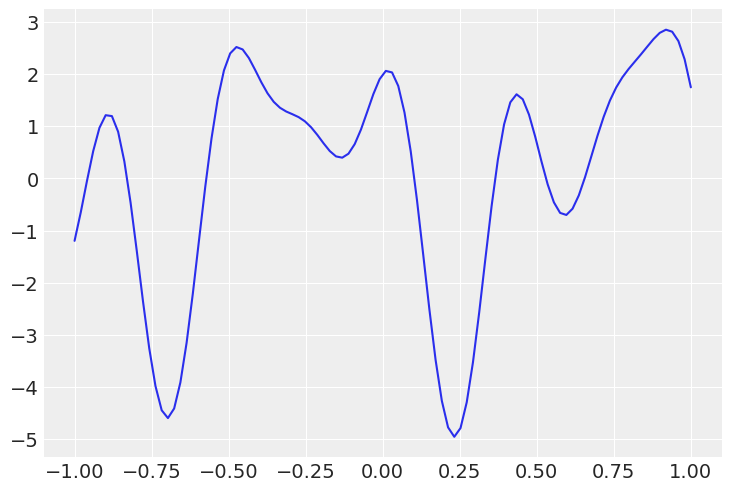

In [3]:
x = np.linspace(-1, 1, 100)
y = f(x)
plt.plot(x, y)

In [4]:
kernel = gp.kernels.RBF(input_dim=1, variance=torch.tensor(6.0), lengthscale=torch.tensor(1))

In [5]:
gpr = gp.models.GPRegression(torch.from_numpy(x), torch.from_numpy(y), kernel, noise=torch.tensor(0.1))

In [6]:
n = 100
Xtest = torch.linspace(-1, 1, n) #inputs
noise = gpr.noise

cov = kernel.forward(Xtest) + noise.expand(n).diag()
samples = dist.MultivariateNormal(torch.zeros(n), covariance_matrix = cov).sample(sample_shape=(5,))


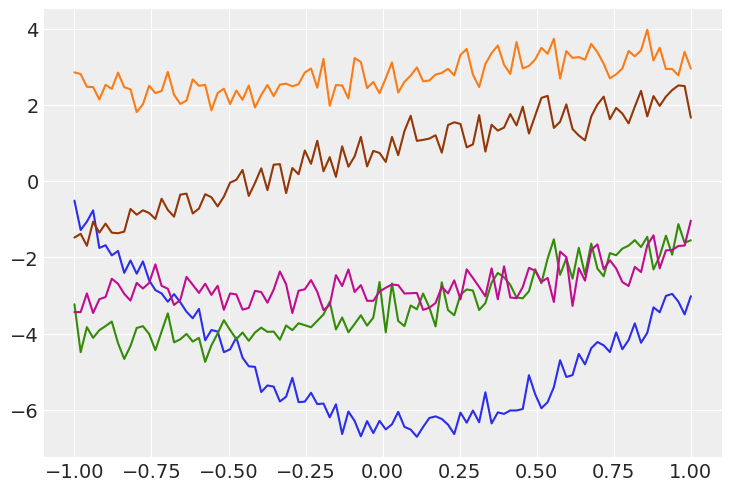

In [7]:
for i in range(5):
    plt.plot(Xtest.numpy(), samples.numpy()[i,:])


In [8]:
samples.shape

torch.Size([5, 100])

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variances = []
lengthscales = []
noises = []
num_steps = 1000
for i in range(num_steps):
    variances.append(gpr.kernel.variance.item())
    noises.append(gpr.noise.item())
    lengthscales.append(gpr.kernel.lengthscale.item())
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

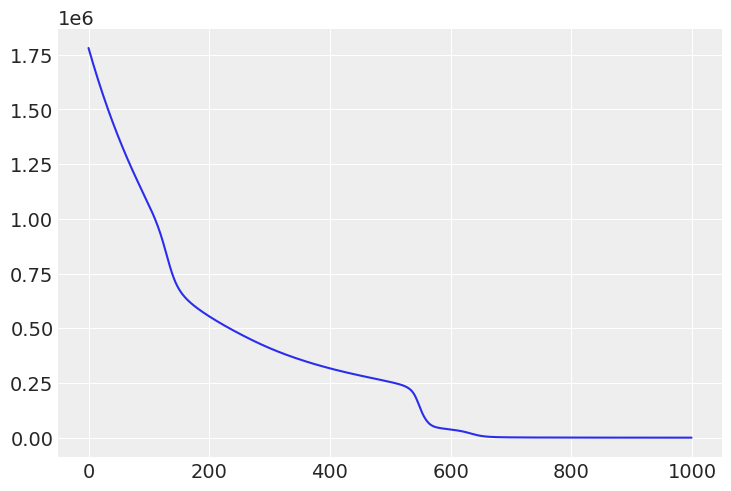

In [9]:
pyro.clear_param_store()
kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(2.0), lengthscale=torch.tensor(3.0)
)
gpr = gp.models.GPRegression(torch.tensor(x), torch.tensor(y), kernel, noise=torch.tensor(10**(-4)))

# note that our priors have support on the positive reals
#gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
#gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 1000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)



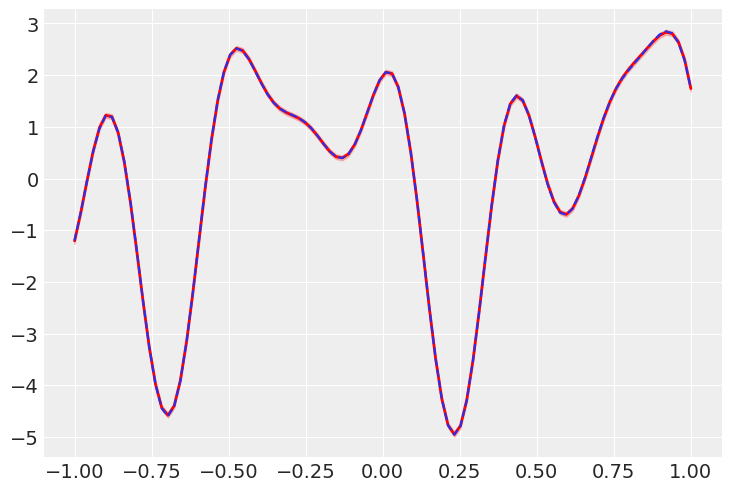

In [10]:

# compute predictive mean and variance
with torch.no_grad():
    mean, cov = gpr(torch.from_numpy(x), full_cov=True, noiseless=False)

sd = cov.diag().sqrt()  # standard deviation at each input point x
plt.plot(x, mean.numpy(), "r", lw=2)  # plot the mean
plt.fill_between(
    x,  # plot the two-sigma uncertainty about the mean
    (mean - 2.0 * sd).numpy(),
    (mean + 2.0 * sd).numpy(),
    color="r",
    alpha=0.2,
)
plt.plot(x, y, ls='--')

100


Sample: 100%|██████████| 1000/1000 [00:27, 36.86it/s, step size=2.91e-01, acc. prob=0.946]


array([<AxesSubplot: title={'center': 'kernel.lengthscale'}>,
       <AxesSubplot: title={'center': 'kernel.variance'}>], dtype=object)

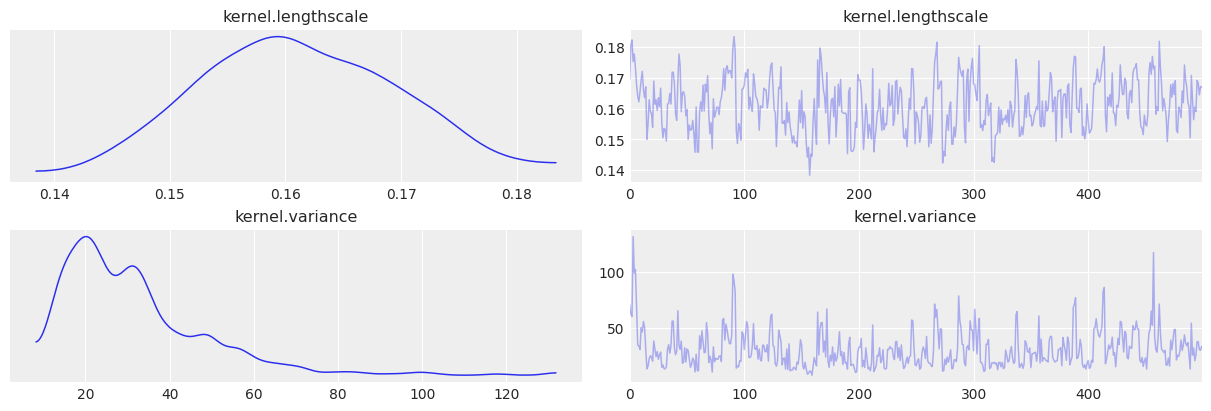

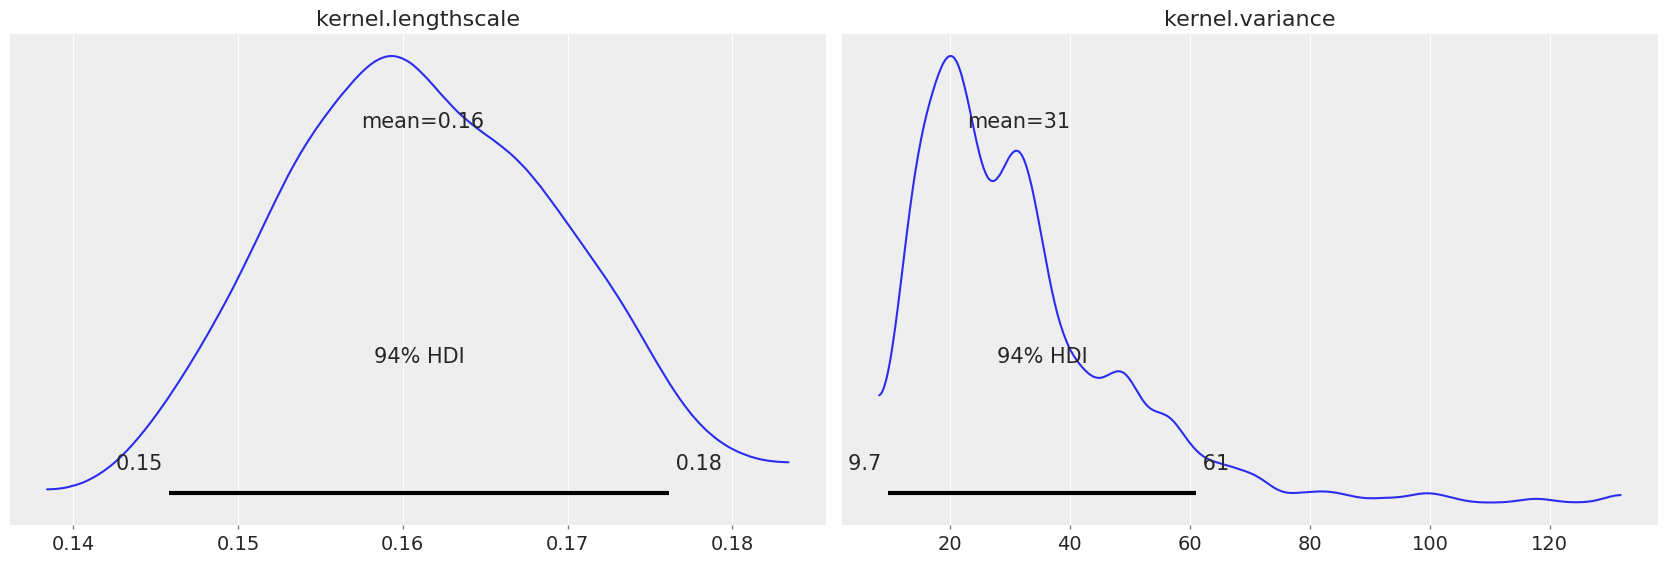

In [11]:
# trying with MCMCM

print(len(x))

pyro.clear_param_store()

kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(2.0), lengthscale=torch.tensor(2.0)
)
gpr = gp.models.GPRegression(torch.tensor(x), torch.tensor(y), kernel, noise=torch.tensor(10.0**(-4)))

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(-1.0, 1.0))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))

nuts_kernel = NUTS(gpr.model)
mcmc = MCMC(nuts_kernel, num_samples=500)
mcmc.run()

posterior_ls = mcmc.get_samples()["kernel.lengthscale"]
posterior_var = mcmc.get_samples()['kernel.variance']

az.plot_trace(mcmc.get_samples(),compact=False)
az.plot_posterior(mcmc.get_samples())

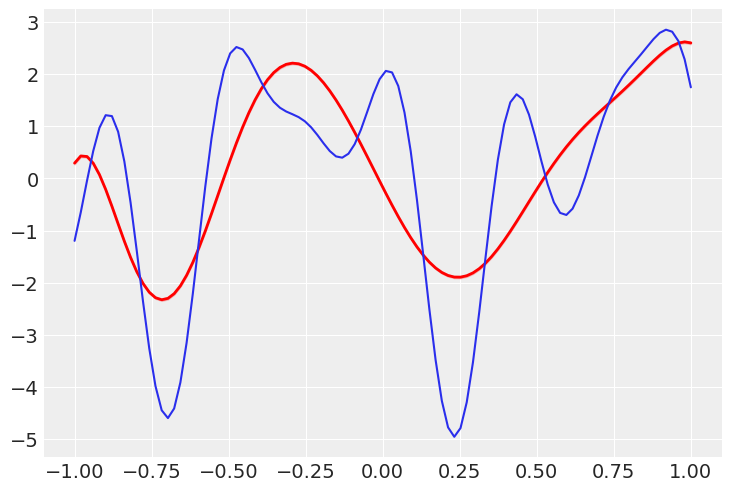

In [12]:
# compute predictive mean and variance
with torch.no_grad():
    mean, cov = gpr(torch.from_numpy(x), full_cov=True, noiseless=False)

sd = cov.diag().sqrt()  # standard deviation at each input point x
plt.plot(x, mean.numpy(), "r", lw=2)  # plot the mean
plt.fill_between(
    x,  # plot the two-sigma uncertainty about the mean
    (mean - 2.0 * sd).numpy(),
    (mean + 2.0 * sd).numpy(),
    color="r",
    alpha=0.2,
)
plt.plot(x, y)

array([<AxesSubplot: title={'center': 'kernel.lengthscale'}>,
       <AxesSubplot: title={'center': 'kernel.variance'}>], dtype=object)

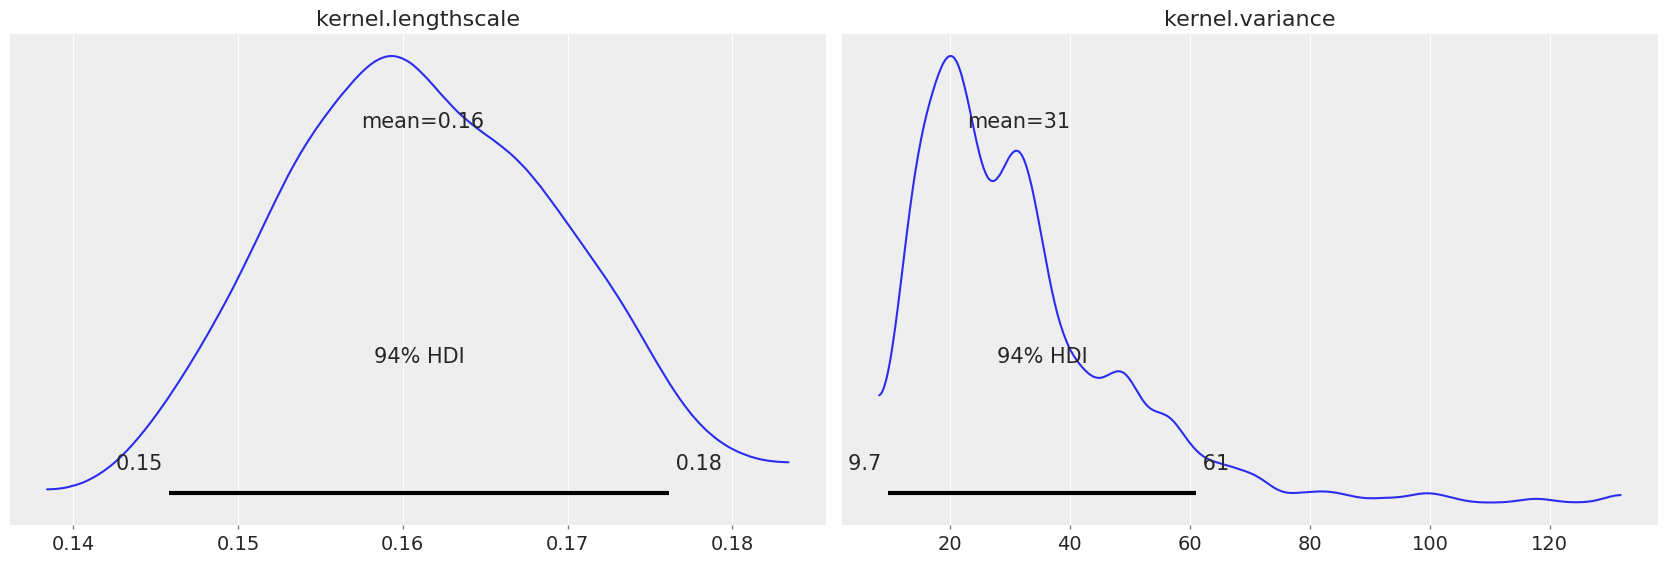

In [13]:
az.plot_posterior(mcmc.get_samples())

array([<AxesSubplot: title={'center': 'kernel.lengthscale'}>,
       <AxesSubplot: title={'center': 'kernel.variance'}>], dtype=object)

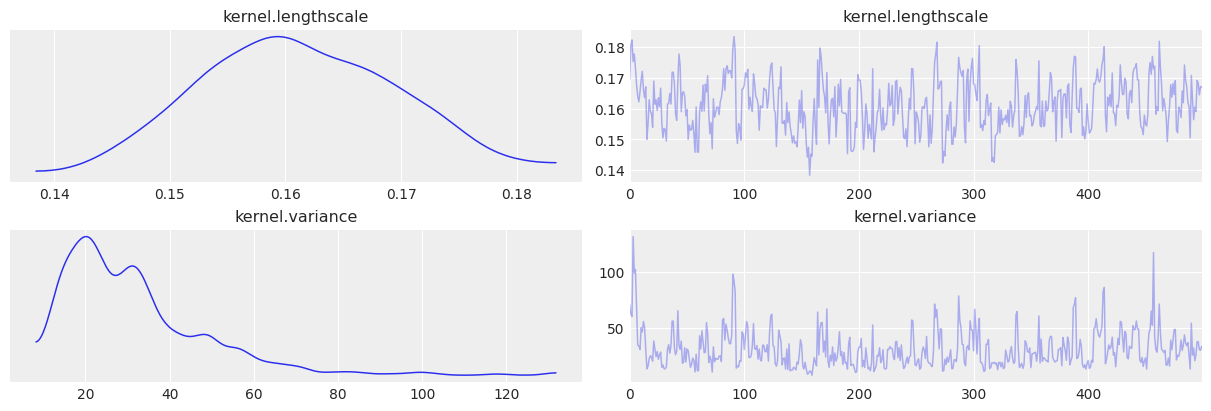

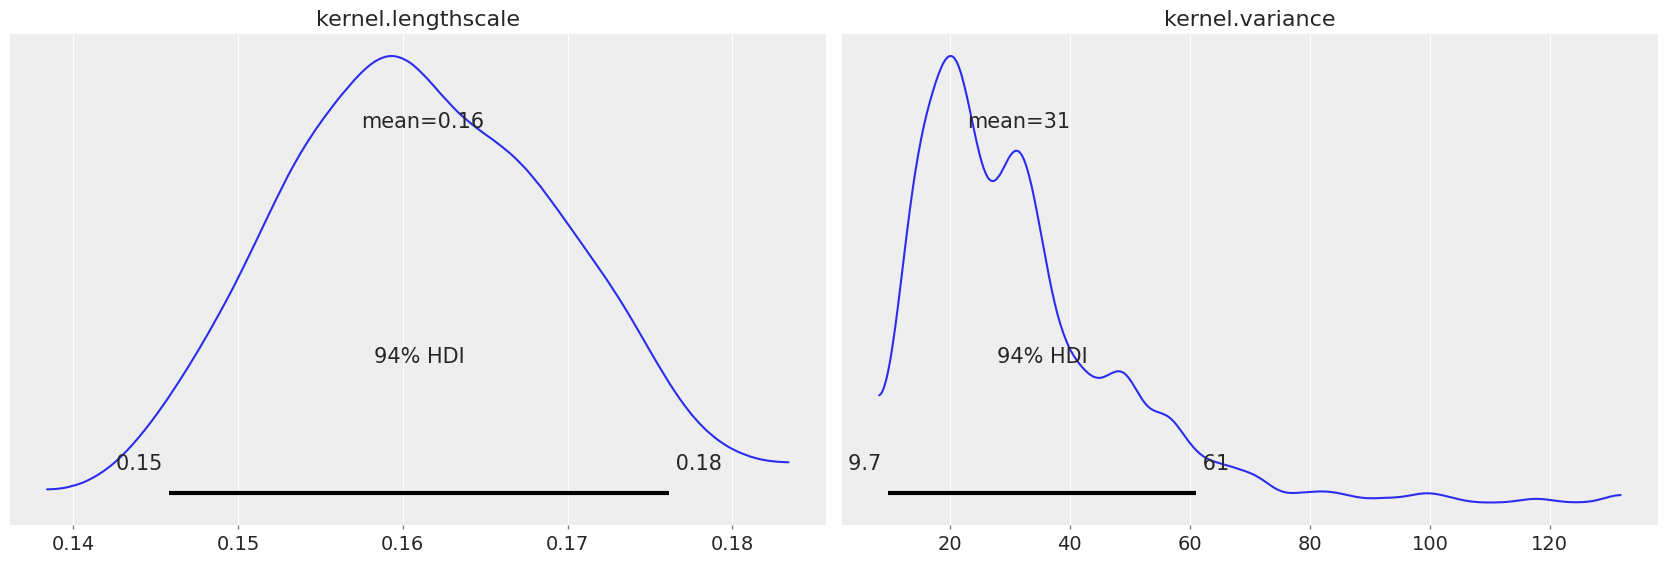

In [14]:
az.plot_trace(mcmc.get_samples(),compact=False)

az.plot_posterior(mcmc.get_samples())


# Actual exam

In [155]:
def f(x):
    return np.sin(20*x) + 2*np.cos(14*x) - 2*np.sin(6*x)

# dataset
x = torch.tensor([-1.0, -0.5, 0.0, 0.5, 1.0])
y = f(x)

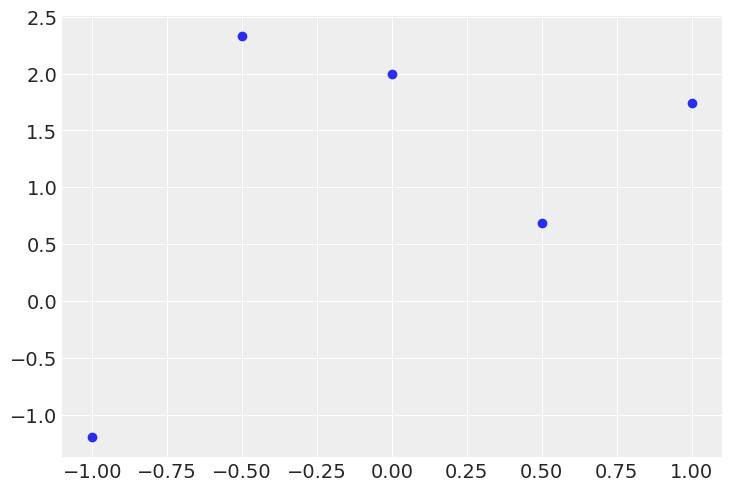

In [156]:
plt.scatter(x, y)

/var/folders/j4/79pszr2s63x4pyfdwfp6509r0000gp/T/ipykernel_76694/1732884807.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gpr = gp.models.GPRegression(torch.tensor(x), torch.tensor(y), kernel, noise=torch.tensor(10.0**(-4)))
Sample: 100%|██████████| 1000/1000 [00:18, 53.27it/s, step size=2.74e-01, acc. prob=0.965]


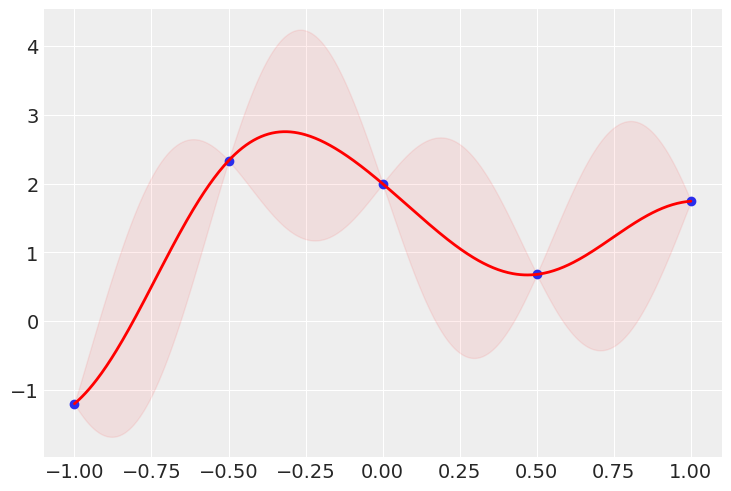

In [157]:
# trying with MCMCM
n_iterations = 1 # testing for generating the same E[theta] of posteriors 

for _ in range(1):
    pyro.clear_param_store()

    kernel = gp.kernels.RBF(
        input_dim=1, variance=torch.tensor(5.0), lengthscale=torch.tensor(10.0)
    )
    gpr = gp.models.GPRegression(torch.tensor(x), torch.tensor(y), kernel, noise=torch.tensor(10.0**(-4)))

    # note that our priors have support on the positive reals
    gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(-1.0, 1.0))
    gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))

    nuts_kernel = NUTS(gpr.model)
    mcmc = MCMC(nuts_kernel, num_samples=500)
    mcmc.run()

    posterior_ls = mcmc.get_samples()["kernel.lengthscale"]
    posterior_var = mcmc.get_samples()['kernel.variance']

    v = mcmc.get_samples()['kernel.variance'].mean()
    ls = mcmc.get_samples()['kernel.lengthscale'].mean()

    # compute predictive mean and variance
    x_ = torch.linspace(-1, 1, 500)

    with torch.no_grad():
        gpr.kernel.lengthscale = ls
        gpr.kernel.variance = v
        mean, cov = gpr(x_, full_cov=True, noiseless=False)

    sd = cov.diag().sqrt()  # standard deviation at each input point x
    plt.plot(x_.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
    plt.fill_between(
        x_,  # plot the two-sigma uncertainty about the mean
        (mean - 2.0 * sd).numpy(),
        (mean + 2.0 * sd).numpy(),
        color="r",
        alpha=0.07,
    )
    plt.scatter(x, y)
#sns.displot(posterior_ls), sns.displot(posterior_var)

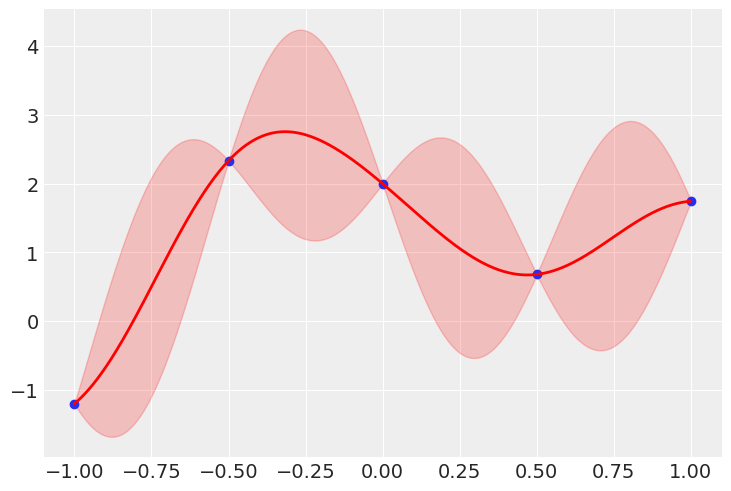

In [158]:
# compute predictive mean and variance
x_ = torch.linspace(-1, 1, 500)

with torch.no_grad():
    gpr.kernel.lengthscale = ls
    gpr.kernel.variance = v
    mean, cov = gpr(x_, full_cov=True, noiseless=False)

sd = cov.diag().sqrt()  # standard deviation at each input point x
plt.plot(x_.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
plt.fill_between(
    x_,  # plot the two-sigma uncertainty about the mean
    (mean - 2.0 * sd).numpy(),
    (mean + 2.0 * sd).numpy(),
    color="r",
    alpha=0.2,
)
plt.scatter(x, y)

array([<AxesSubplot: title={'center': 'kernel.lengthscale'}>,
       <AxesSubplot: title={'center': 'kernel.variance'}>], dtype=object)

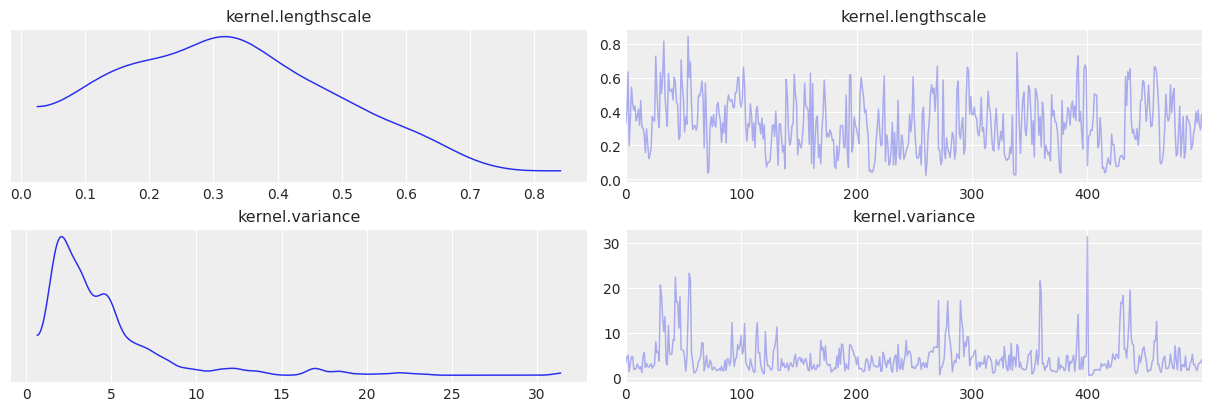

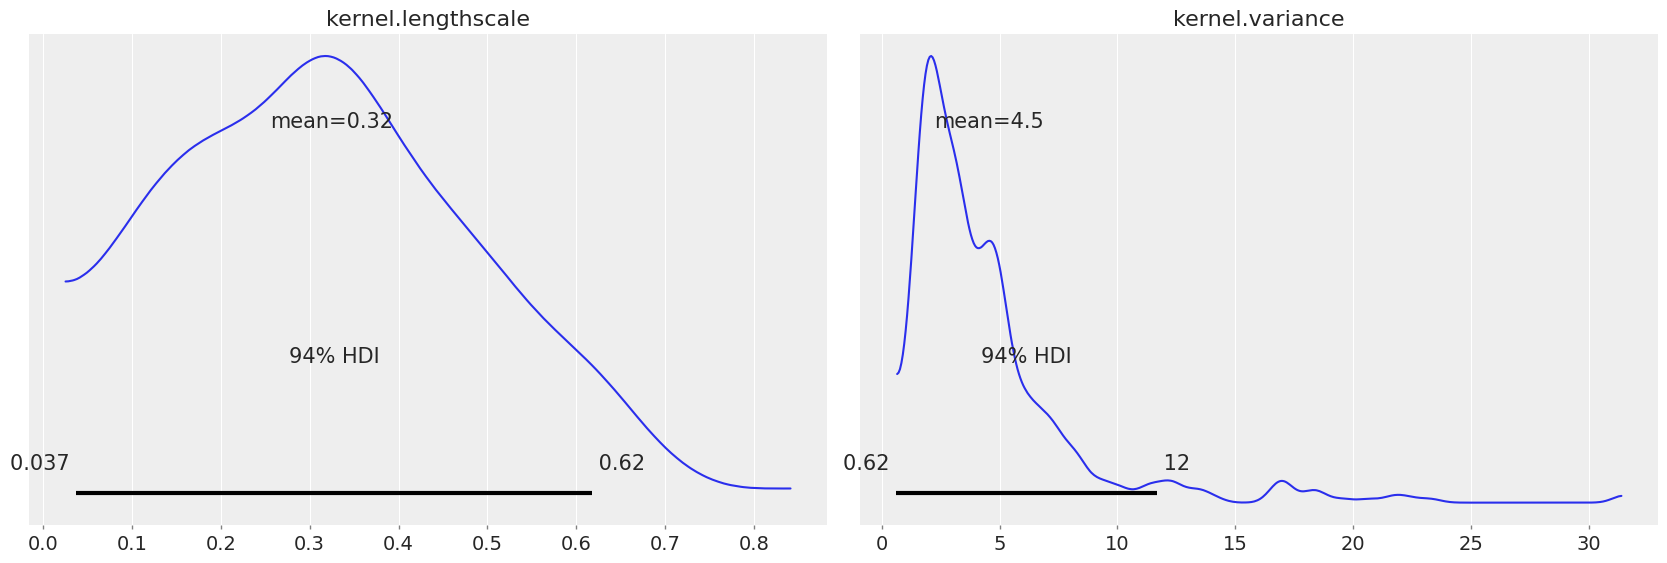

In [159]:
az.plot_trace(mcmc.get_samples(),compact=False)

az.plot_posterior(mcmc.get_samples())


# B2

/var/folders/j4/79pszr2s63x4pyfdwfp6509r0000gp/T/ipykernel_76694/1226495679.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gpr = gp.models.GPRegression(torch.tensor(x), torch.tensor(y), kernel, noise=torch.tensor(10.0**(-4)))
Sample: 100%|██████████| 400/400 [00:09, 42.53it/s, step size=7.38e-01, acc. prob=0.761]
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
Sample: 100%|██████████| 400/400 [00:07, 54.14it/s, step size=6.81e-01, acc. prob=0.907]
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precede

iteration: 6. ix was 15


Sample: 100%|██████████| 400/400 [00:07, 50.71it/s, step size=5.20e-01, acc. prob=0.925]
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


iteration: 7. ix was 15
iteration: 7. ix was 14


Sample: 100%|██████████| 400/400 [00:07, 55.94it/s, step size=5.99e-01, acc. prob=0.899]
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


iteration: 8. ix was 15
iteration: 8. ix was 14
iteration: 8. ix was 16


Sample: 100%|██████████| 400/400 [00:09, 41.84it/s, step size=5.33e-01, acc. prob=0.913]
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


iteration: 9. ix was 15
iteration: 9. ix was 14
iteration: 9. ix was 16
iteration: 9. ix was 13
iteration: 9. ix was 17
iteration: 9. ix was 12
iteration: 9. ix was 18


Sample: 100%|██████████| 400/400 [00:09, 42.08it/s, step size=5.84e-01, acc. prob=0.885]
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


iteration: 10. ix was 15
iteration: 10. ix was 14
iteration: 10. ix was 16
iteration: 10. ix was 13
iteration: 10. ix was 17
iteration: 10. ix was 12
iteration: 10. ix was 18
iteration: 10. ix was 11


Sample: 100%|██████████| 400/400 [00:10, 37.05it/s, step size=3.18e-01, acc. prob=0.951]
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


iteration: 11. ix was 15
iteration: 11. ix was 14
iteration: 11. ix was 16
iteration: 11. ix was 13
iteration: 11. ix was 17
iteration: 11. ix was 12
iteration: 11. ix was 18
iteration: 11. ix was 11


Sample: 100%|██████████| 400/400 [00:08, 47.00it/s, step size=5.46e-01, acc. prob=0.916]
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
Sample: 100%|██████████| 400/400 [00:08, 47.44it/s, step size=7.02e-01, acc. prob=0.886]
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


iteration: 13. ix was 15
iteration: 13. ix was 14
iteration: 13. ix was 16
iteration: 13. ix was 13
iteration: 13. ix was 17


Sample: 100%|██████████| 400/400 [00:12, 32.46it/s, step size=3.73e-01, acc. prob=0.937]
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
Sample: 100%|██████████| 400/400 [00:08, 49.45it/s, step size=5.68e-01, acc. prob=0.891]
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


iteration: 15. ix was 61


Sample: 100%|██████████| 400/400 [15:45,  2.36s/it, step size=7.15e-07, acc. prob=0.942]
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


iteration: 16. ix was 62
iteration: 16. ix was 61


Sample: 100%|██████████| 400/400 [00:07, 54.56it/s, step size=5.44e-01, acc. prob=0.896]
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


iteration: 17. ix was 61


Sample: 100%|██████████| 400/400 [00:10, 38.56it/s, step size=5.39e-01, acc. prob=0.897]
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


iteration: 18. ix was 61
iteration: 18. ix was 60
iteration: 18. ix was 62
iteration: 18. ix was 15
iteration: 18. ix was 14
iteration: 18. ix was 16


Sample: 100%|██████████| 400/400 [00:07, 53.27it/s, step size=6.33e-01, acc. prob=0.907]
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


iteration: 19. ix was 61
iteration: 19. ix was 62
iteration: 19. ix was 60
iteration: 19. ix was 15
iteration: 19. ix was 14
iteration: 19. ix was 16
tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000, -0.9394, -0.1515, -0.6566,
        -0.6364, -0.7576, -0.6970, -0.7172, -0.6768, -0.7374, -0.7778, -0.2727,
        -0.6162,  0.2929,  0.3131,  0.2323,  0.2525,  0.2727,  0.2121,  0.7980,
         0.1919])


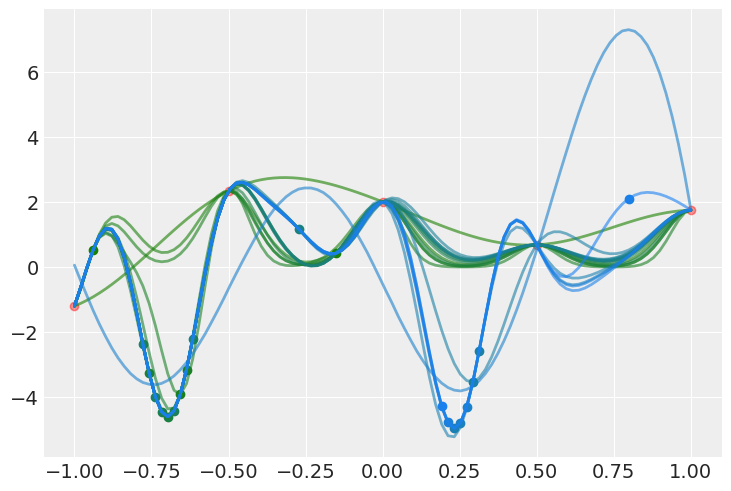

In [161]:
# compute predictive mean and variance
n_samples = 200
n_iterations = 20
REMOVE_REPEATS = True

def ix_delete(tensor, indices):
    mask = torch.ones(tensor.numel(), dtype=torch.bool)
    mask[indices] = False
    return tensor[mask]

used_indices = list()


x = torch.tensor([-1.0, -0.5, 0.0, 0.5, 1.0])
y = f(x)

plt.scatter(x, y, color='red', alpha=0.4)


for i in range(n_iterations):
    color = (0.1, 0.5, i / n_iterations)

    y = f(x)

    
    #if i > 0:
    #    plotter(color)

    pyro.clear_param_store()

    kernel = gp.kernels.RBF(
        input_dim=1, variance=torch.tensor(5.0), lengthscale=torch.tensor(10.0)
    )
    gpr = gp.models.GPRegression(torch.tensor(x), torch.tensor(y), kernel, noise=torch.tensor(10.0**(-4)))

    # note that our priors have support on the positive reals
    gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(-1.0, 1.0))
    gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))

    nuts_kernel = NUTS(gpr.model)
    mcmc = MCMC(nuts_kernel, num_samples=n_samples)
    mcmc.run()

    posterior_ls = mcmc.get_samples()["kernel.lengthscale"]
    posterior_var = mcmc.get_samples()['kernel.variance']

    v = mcmc.get_samples()['kernel.variance'].mean()
    ls = mcmc.get_samples()['kernel.lengthscale'].mean()

    x_star = torch.linspace(-1, 1, 100)

    with torch.no_grad():
        gpr.kernel.lengthscale = ls
        gpr.kernel.variance = v
        mean, cov = gpr(x_star, full_cov=True, noiseless=False)

    y_star = pyro.distributions.MultivariateNormal(mean, cov).sample()
    
    temp_indices = list()

    ix = y_star.argmin()

    if REMOVE_REPEATS:

        while ix in used_indices:
            print(f'iteration: {i}. ix was {ix}')
            temp_indices.append(ix)
            y_star[ix] = torch.tensor(9999.9) # just setting arbitrary high value so not being argmin
            ix = y_star.argmin()

    used_indices.append(ix)

    new_x = x_star[ix]

    x = torch.cat([x, new_x.expand(1)])

    sd = cov.diag().sqrt()  # standard deviation at each input point x
    plt.plot(x_star.numpy(), mean.numpy(), lw=2, c=color, label=f'iter {i}', alpha=0.6)  # plot the mean
    #plt.fill_between(
    #    x_,  # plot the two-sigma uncertainty about the mean
    #    (mean - 2.0 * sd).numpy(),
    #    (mean + 2.0 * sd).numpy(),
    #    color="r",
    #    alpha=0.2,
    #)
    def plotter(c):
        return plt.scatter(new_x.numpy(), f(new_x).numpy(), c=c)

    plt.scatter(new_x.numpy(), f(new_x).numpy(), c=color)


print(x)
#plt.legend()


        

/var/folders/j4/79pszr2s63x4pyfdwfp6509r0000gp/T/ipykernel_76694/3466435592.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gpr = gp.models.GPRegression(torch.tensor(x), torch.tensor(y), kernel, noise=torch.tensor(10.0**(-4)))
Sample: 100%|██████████| 400/400 [00:05, 68.53it/s, step size=5.26e-01, acc. prob=0.856] 
/var/folders/j4/79pszr2s63x4pyfdwfp6509r0000gp/T/ipykernel_76694/3466435592.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gpr = gp.models.GPRegression(torch.tensor(x), torch.tensor(y), kernel, noise=torch.tensor(10.0**(-4)))
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its lengt

iteration: 1. ix was 0
iteration: 2. ix was 0
iteration: 2. ix was 1
iteration: 3. ix was 0
iteration: 3. ix was 1
iteration: 3. ix was 2
iteration: 4. ix was 0
iteration: 4. ix was 1
iteration: 4. ix was 2
iteration: 5. ix was 0
iteration: 7. ix was 0
iteration: 8. ix was 0
iteration: 8. ix was 79
iteration: 8. ix was 1
iteration: 8. ix was 80
iteration: 9. ix was 0
iteration: 9. ix was 79
iteration: 9. ix was 80
iteration: 9. ix was 78
iteration: 9. ix was 1
iteration: 10. ix was 0
iteration: 10. ix was 79
iteration: 10. ix was 78
iteration: 10. ix was 1
iteration: 10. ix was 80
iteration: 10. ix was 81
iteration: 11. ix was 0
iteration: 11. ix was 79
iteration: 11. ix was 1
iteration: 11. ix was 78
iteration: 11. ix was 80
iteration: 11. ix was 77
iteration: 11. ix was 81
iteration: 12. ix was 0
iteration: 12. ix was 79
iteration: 12. ix was 1
iteration: 12. ix was 80
iteration: 12. ix was 78
iteration: 12. ix was 77
iteration: 12. ix was 81
iteration: 12. ix was 76
iteration: 13. i

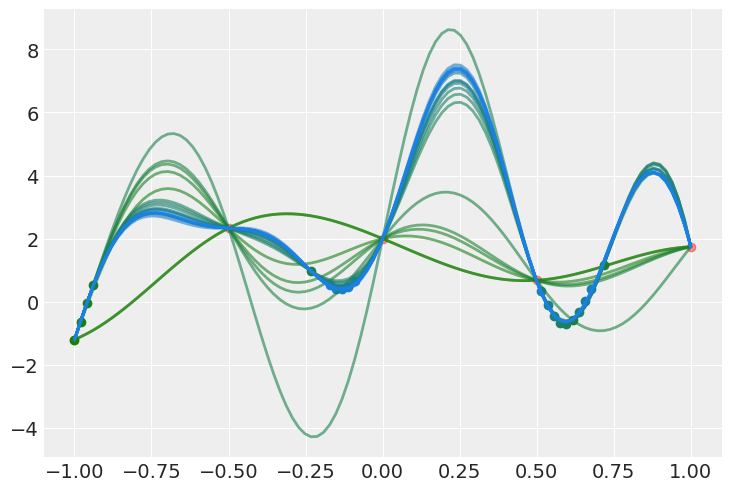

In [180]:
# compute predictive mean and variance
n_samples = 200
n_iterations = 20
REMOVE_REPEATS = True

def ix_delete(tensor, indices):
    mask = torch.ones(tensor.numel(), dtype=torch.bool)
    mask[indices] = False
    return tensor[mask]

used_indices = list()

ls_list, v_list = list(), list()

x = torch.tensor([-1.0, -0.5, 0.0, 0.5, 1.0])
y = f(x)

plt.scatter(x, y, color='red', alpha=0.4)

pyro.clear_param_store()

kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(5.0), lengthscale=torch.tensor(10.0)
)
gpr = gp.models.GPRegression(torch.tensor(x), torch.tensor(y), kernel, noise=torch.tensor(10.0**(-4)))

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(-1.0, 1.0))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))

nuts_kernel = NUTS(gpr.model)
mcmc = MCMC(nuts_kernel, num_samples=n_samples)
mcmc.run()

post_ls = mcmc.get_samples()["kernel.lengthscale"]
post_var = mcmc.get_samples()['kernel.variance']



for i in range(n_iterations):
    color = (0.1, 0.5, i / n_iterations)

    y = f(x)
    
    #pyro.clear_param_store()

    v = post_var[-(i+1)]
    ls = post_ls[-(i+1)]

    v_list.append(v)
    ls_list.append(ls)

    x_star = torch.linspace(-1, 1, 100)

    kernel = gp.kernels.RBF(
        input_dim=1, variance=v, lengthscale=ls
    )
    gpr = gp.models.GPRegression(torch.tensor(x), torch.tensor(y), kernel, noise=torch.tensor(10.0**(-4)))

    with torch.no_grad():
        gpr.kernel.lengthscale = ls
        gpr.kernel.variance = v
        mean, cov = gpr(x_star, full_cov=True, noiseless=False)

    y_star = pyro.distributions.MultivariateNormal(mean, cov).sample()
    
    temp_indices = list()

    ix = y_star.argmin()

    if REMOVE_REPEATS:

        while ix in used_indices:
            print(f'iteration: {i}. ix was {ix}')
            temp_indices.append(ix)
            y_star[ix] = torch.tensor(9999.9) # just setting arbitrary high value so not being argmin
            ix = y_star.argmin()

    used_indices.append(ix)

    new_x = x_star[ix]

    x = torch.cat([x, new_x.expand(1)])

    sd = cov.diag().sqrt()  # standard deviation at each input point x
    plt.plot(x_star.numpy(), mean.numpy(), lw=2, c=color, label=f'iter {i}', alpha=0.6)  # plot the mean
    #plt.fill_between(
    #    x_,  # plot the two-sigma uncertainty about the mean
    #    (mean - 2.0 * sd).numpy(),
    #    (mean + 2.0 * sd).numpy(),
    #    color="r",
    #    alpha=0.2,
    #)
    def plotter(c):
        return plt.scatter(new_x.numpy(), f(new_x).numpy(), c=c)

    plt.scatter(new_x.numpy(), f(new_x).numpy(), c=color)

print(x)
#plt.legend()

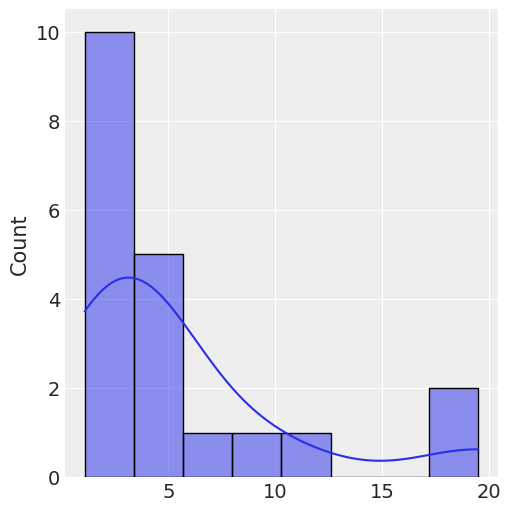

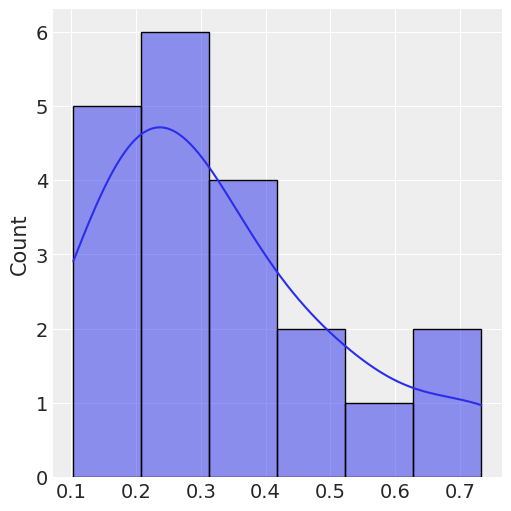

In [181]:
sns.displot(torch.cat([i.expand(1) for i in v_list]).numpy(), kde=True)
sns.displot(torch.cat([i.expand(1) for i in ls_list]).numpy(), kde=True)

In [234]:
gamma = post_ls.mean()
var = post_var.mean()

#tensor(0.3276) tensor(4.7225)

def k(xi, xj):
    gamma = torch.tensor(0.3276, requires_grad=True) # mean of psoterior
    return torch.exp(-torch.norm(xi - xj)**2)

def Kx(S, x):
    size = S.shape[0]
    K = torch.ones(size=(size, ), requires_grad=True)
    for i in range(size):
        K[i] = k(S[i], x)
    return K

def KS(S):
    size = S.shape[0]
    K = torch.ones(size=(size, size), requires_grad=True)
    for i in range(size):
        for j in range(size):
            K[i, j] = k(S[i], S[j])

    return K

def mu(S, x_star, y):
    var = torch.tensor(4.7225, requires_grad=True)
    size = S.shape[0]
    res = Kx(S, x).T  @ (KS(S) + var*torch.eye(size, requires_grad=True)).inverse() @ y
    return res #+ var*torch.eye(size)).inverse() @ y

res = mu(x[0: 5], torch.tensor(0.25), y[0:5])



RuntimeError: a view of a leaf Variable that requires grad is being used in an in-place operation.

In [233]:
res.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [191]:
S.apply_(k)

TypeError: k() missing 1 required positional argument: 'xj'

In [192]:
S.shape

torch.Size([2, 2])